<a href="https://colab.research.google.com/github/EgeSarii/Reinforcement-Learning/blob/branch_ege/6-Summary-assignments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reinforcement Learning 6: *Planning and learning with tabular methods*

**Assignment:** Hand-in until 28/03/2022

This week's assignment intends to summarize and compare the concepts and methods taught throughout the course.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import time

---

#### Circle world

Imagine an agent navigating a circular environment, a simple circular track comprising `n_states=10`. At any point in time, the agent may choose to step `left` or `right`. All steps have reward $-1/(N-1)$ except for state 0 with reward 1. States 0 and $N$ are connected to form a circle.

The example tasks for this assignment comprise a summary of all the content taught in the course:
 1. *Week2*: MDPs
 2. *Week3*: Dynamic Programming
 3. *Week4*: Monte Carlo methods
 4. *Week5*: TD-learning

We start by defining the environments / tasks:

In [27]:
class FiniteMDP():
    """
    Generic base class for MDPs with finite state, action and reward spaces
    """
    def __init__(self, n_states, n_actions, reward, task, gamma=1.0, state_labels=None, action_labels=None):
        """
        n_states: number of states [0,...,N-1]
        n_actions: number of actions [0,...,N-1]
        reward: reward values
        task: episodic or continuing
        gamma: discounting factor
        """
        self.n_states = n_states
        self.n_actions = n_actions
        self.state_labels = state_labels or np.arange(self.n_states)
        self.action_labels = action_labels or np.arange(self.n_actions)
        self.n_rewards = len(reward)
        self.reward = reward
        assert(task == 'episodic' or task == 'continuing')
        self.task = task
        self.gamma = gamma

    def p_initial(self, s):
        """
        Probability for an initial state; assumed uniform
        """
        return 1 / self.n_states

    def sample_initial(self):
        """
        Sample initial state at start of the episode; assumed uniform
        """
        return np.random.randint(self.n_states)

    def p_transition(self, s, a, s1, r):
        """
        Transition density s x a => s1 x r
        """
        # This only works for deterministic state transitions; otherwise override
        return np.float((s1, r) == self.sample_transition(s, a))

    def sample_transition(self, s, a):
        """
        Sample new state and reward when starting in s and taking action a
        """
        raise NotImplementedError

    def sample_action(self, state, policy):
        # sample action from policy for a given state
        return np.random.choice(np.arange(self.n_actions), p=policy[state])

    def sample_sequence(self, policy, T=None):
        """
        Sample a finite horizon sequence from an MDP using some policy
        If the tasks is continuing then we sample exactly T steps
        If the task is episodic then we sample exactly one episode or reset until we sample T steps
        """
        # sequence element is state, action, reward
        seq = []
        # randomly sample initial state NOTE: For exploring starts we would need to sample both states and actions. This is not needed for epsilon-greedy policies
        s = self.sample_initial()

        if self.task == 'continuing':
            assert (T is not None)
            for t in range(T):
                a = self.sample_action(s, policy)
                (s1, r) = self.sample_transition(s, a)
                seq.append([s, a, self.reward[r]])
                s = s1
        else:
            t = 0
            while True:

                if T is None and self.is_terminal(s):
                    break
                elif t == T:
                    break

                a = self.sample_action(s, policy)
                if self.is_terminal(s):
                    s1 = self.sample_initial()
                    r = 0
                else:
                    (s1, r) = self.sample_transition(s, a)
                seq.append([s, a, self.reward[r]])
                s = s1
                t = t+1
        return seq

    def random_deterministic_policy(self):
        """
        Random choice of a deterministic action for each state
        """
        return np.random.multinomial(1, [1.0 / self.n_actions for a in range(self.n_actions)], self.n_states).astype('float32')

    def nonterminal_states(self):
        """
        :return: The set S of nonterminal states
        """
        return [s for s in range(self.n_states) if not self.is_terminal(s)]

    def terminal_states(self):
        """
        :return: The set S of terminal states
        """
        return [s for s in range(self.n_states) if self.is_terminal(s)]

    def is_terminal(self, s):
        """
        flags if s is a terminal state
        """
        return False  # must be implemented for episodic tasks

    def __str__(self):
        str = "task: {0}\n".format(self.task)
        str += "states: {0}\n".format(self.state_labels)
        if self.terminal_states():
            str += "terminal states: {0}\n".format(self.terminal_states())
        str += "actions: {0}\n".format(self.action_labels)
        str += "rewards: {0}\n".format(self.reward)
        str += "discounting factor: {0}".format(self.gamma)
        return str

    def print_policy(self, policy):
        for s in range(self.n_states):
            a = np.random.choice(np.arange(self.n_actions), p=policy[s])
            print('state ' + str(self.state_labels[s]) + ' => action ' + str(self.action_labels[a]))

    def print_value(self, vf):
        """
        :param vf: state value or action value function
        """
        if vf.ndim == 1:
            for s in range(self.n_states):
                print('state ' + str(self.state_labels[s]) + ': ' + str(vf[s]))
        else:
            for s in range(self.n_states):
                for a in range(self.n_actions):
                    print('state ' + str(self.state_labels[s]) + ' - action ' + str(self.action_labels[a] + ': ' + str(vf[s,a])))

    def q_to_v(self, q, policy):
        v = np.zeros(self.n_states)
        for s in self.nonterminal_states():
            for a in range(self.n_actions):
                v[s] += policy[s, a] * q[s, a]
        return v

    def v_to_q(self, v):
        # Eqn. 4.6 in S&B
        q = np.zeros([self.n_states, self.n_actions])
        for s in self.nonterminal_states():
            for a in range(self.n_actions):
                q[s, a] = sum(self.p_transition(s, a, s1, r) * (self.reward[r] + self.gamma * v[s1])
                              for s1 in range(self.n_states) for r in range(self.n_rewards))
        return q

In [28]:
# Example MDPs used in this assignment
class CircleWorld(FiniteMDP):
    """
    Walk on the circle. All steps have reward -1/(N-1)  except for state 0 with reward 1. States 0 and n_states are connected to form a circle
    """
    def __init__(self, n_states, gamma=0.99):
        super().__init__(n_states, 2, [1.0, round(-1.0 / (n_states - 1), 2)], 'continuing', gamma=gamma, state_labels=None,
                         action_labels=['L', 'R'])

    def sample_transition(self, s, a):
        s1 = (s + 2 * a - 1) % self.n_states  # takes one step left or right
        if s1 == 0:
            r = 0
        else:
            r = 1
        return s1, r

    def optimal_policy(self):
        """
        For this simple task, the optimal policy is just to move to state zero as quickly as possible
        and then flip back and forth
        """
        policy = np.zeros([self.n_states, self.n_actions])
        n = int(np.round(self.n_states/2))
        policy[:n, 0] = 1.0
        policy[n:, 1] = 1.0
        policy[self.terminal_states(), :] = 1.0 / self.n_actions
        return policy


class CircleWorldEpisodic(CircleWorld):
    """
    Episodic variant of circle world
    """
    def __init__(self, n_states, gamma=0.99):
        super().__init__(n_states, gamma=gamma)
        self.task = 'episodic'

    def is_terminal(self, s):
        return s == 0

Instantiate the `CircleWorld`:

In [29]:
# We can instantiate it using the generic FiniteMDP class
mdpc = FiniteMDP(n_states=10, n_actions=2, reward=[1.0, -1.0 /(10 - 1), 2], task='continuing', gamma=0.99, state_labels=None, action_labels=['L', 'R'])
print(mdpc)

task: continuing
states: [0 1 2 3 4 5 6 7 8 9]
actions: ['L', 'R']
rewards: [1.0, -0.1111111111111111, 2]
discounting factor: 0.99


In [5]:
# ...or we can use the example classes CircleWorld and CircleWorldEpisodic
print('Circleworld:')
mdpc = CircleWorld(n_states=10, gamma=0.99)
print(mdpc)

Circleworld:
task: continuing
states: [0 1 2 3 4 5 6 7 8 9]
actions: ['L', 'R']
rewards: [1.0, -0.11]
discounting factor: 0.99


### 1. MDP simulation
*(1 point)*

**a**) Consider a uniform, stochastic policy (all actions have equal probability in all states).


In [24]:
def uniform_stochastic_policy(n_states, n_actions):
    """
    Each action has equal probability in all states
    """
    probs = np.zeros((n_states, n_actions))
    for n in range(n_states):
      for a in range(n_actions):
        probs[n][a] = 1/ n_actions
    return probs

**b**) Simulate the MDP and plot the evolution of the return $G_{t}$ obtained under this policy, with discounting factors $\gamma=1$ and $\gamma=0.98$.

In [46]:
mdpc = CircleWorld(n_states=10, gamma=0.98)

policy = uniform_stochastic_policy(mdpc.n_states, mdpc.n_actions)

seq = np.array(mdpc.sample_sequence(policy, 200)).T

discounting = [mdpc.gamma**t for t in range(0, 200)]

Text(0, 0.5, 'return')

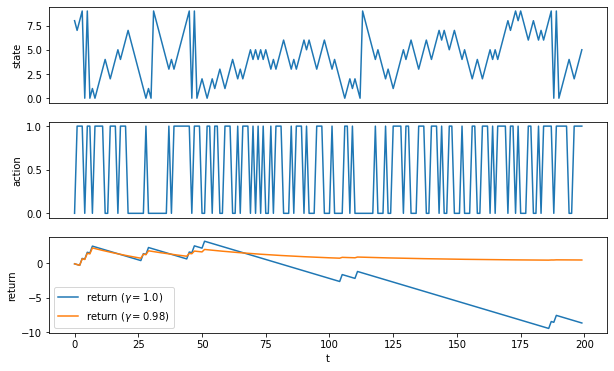

In [47]:
fig, ax = plt.subplots(3, 1, figsize=(10, 6))
ax[0].plot(seq[0],label='state')
ax[0].set_xticks([])
ax[0].set_ylabel('state')
ax[1].plot(seq[1],label='action')
ax[1].set_xticks([])
ax[1].set_ylabel('action')
ax[2].plot(np.cumsum(seq[2]),label='return ($\gamma=$' + str(1.0) + ')' )
ax[2].plot(np.cumsum(seq[2] * discounting),label='return ($\gamma=$' + str(mdpc.gamma) + ')' )
plt.legend()
ax[2].set_xlabel('t')
ax[2].set_ylabel('return')

### 2. Dynamic Programming
*(4 points)*


**a**) Write a policy evaluation function, which computes the state-value function from a policy
*(0.5 points)*

In [54]:
def policy_evaluation(mdp, policy, V=None, theta=1e-8, max_t=None):
    # Conditions for convergence
    assert (mdp.task == 'episodic' or mdp.gamma < 1.0)
    # Init V
    if V is None:
        V = np.zeros(mdp.n_states)
    # Evaluate policy iteratively
    t = 0
    while True:
        t += 1
        delta = 0
        for s in mdp.nonterminal_states():
            val = V[s]
            # TODO: correct the line below
            V[s] = sum(policy[s, a] * mdp.p_transition(s, a, s1, r) * (mdp.reward[r] +  mdp.gamma * V[s1])
                       for a in range(mdp.n_actions) for s1 in range(mdp.n_states) for r in range(mdp.n_rewards))
            # ---
            delta = max(delta, abs(val - V[s]))

        if theta > delta or (max_t and t == max_t):
            break

    return V

**b**) In this simple task, the optimal policy simply requires moving to state 0 as quickly as possible, so we can construct an explicit optimal policy which will be used as baseline for comparison:

In [55]:
# to understand the policy, study the `optimal_policy` method defined above
pi_c = mdpc.optimal_policy()
print(pi_c)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


**b.1**) Evaluate the optimal policy generated above, using the `policy_evaluation` function you implemented above:
*(0.5 points)*

In [56]:
V_c = policy_evaluation(mdpc, uniform_stochastic_policy(mdpc.n_states, mdpc.n_actions))
Q_c = mdpc.v_to_q(V_c)
print(pi_c)
print('\nOptimal policy:')
mdpc.print_policy(pi_c)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]

Optimal policy:
state 0 => action L
state 1 => action L
state 2 => action L
state 3 => action L
state 4 => action L
state 5 => action R
state 6 => action R
state 7 => action R
state 8 => action R
state 9 => action R


**b.2**) Repeat the steps above for the episodic version of the task, using `CircleWorldEpisodic`:
*(0.5 points)*


In [66]:
print('\nEpisodic circleworld:')
mdpe = CircleWorldEpisodic(n_states=10,  gamma=0.99)
print(mdpe)


Episodic circleworld:
task: episodic
states: [0 1 2 3 4 5 6 7 8 9]
terminal states: [0]
actions: ['L', 'R']
rewards: [1.0, -0.11]
discounting factor: 0.99


In [67]:
# compute state and action value of the optimal policy for the continous problem
pi_e = mdpe.optimal_policy()

# TODO: optimal policy / baseline
V_e = policy_evaluation(mdpe, uniform_stochastic_policy(mdpe.n_states, mdpe.n_actions))
# TODO: evaluate optimal policy
Q_e = mdpe.v_to_q(V_e)
print('\nOptimal policy:')
mdpc.print_policy(pi_e)


Optimal policy:
state 0 => action L
state 1 => action L
state 2 => action L
state 3 => action L
state 4 => action L
state 5 => action R
state 6 => action R
state 7 => action R
state 8 => action R
state 9 => action R


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


**c**) Policy iteration VS value iteration

**c.1**) Correct/complement the implementation of `policy_improvement`:
*(0.5 points)*

In [68]:
def policy_improvement(mdp, policy, V):
    """
    Policy improvement operates directly on the input policy
    """
    policy_stable = True
    for s in mdp.nonterminal_states():
        # deterministic version
        old_action = np.argmax(policy[s])
        action_values = np.zeros(mdp.n_actions)
        for a in range(mdp.n_actions):
            # TODO: correct line below
            action_values[a] = sum(mdp.p_transition(s, a, s1, r) * (mdp.reward[r] + mdp.gamma * V[s1])
                                   for s1 in range(mdp.n_states) for r in range(mdp.n_rewards))
        best_action = np.argmax(action_values)

        # Update Policy
        policy[s, :] = 0
        policy[s, best_action] = 1
        policy_changed = old_action != best_action
        if policy_changed:
            policy_stable = False
    return policy, policy_stable

**c.2**) Correct/complement the implementation of `policy_iteration`:
*(0.75 points)*

In [70]:
def policy_iteration(mdp, policy):
    """
    returns policy and list of list of value estimates per state and wall-clock time
    operates directly on the input policy
    """
    start = time.time()
    V = None
    Vs = []
    while True:
        V = policy_evaluation(mdp, policy)
        policy, policy_stable = policy_improvement(mdp,policy, V)
        Vs.append(copy.copy(V))
        if policy_stable:
            break
    end = time.time()

    return policy, Vs, end - start

**c.3**) Correct/complement the implementation of `value_iteration`:
*(0.75 points)*

In [77]:
def policy_construction(mdp, V):
    """
    Derive policy from value function
    """
    policy = np.ones([mdp.n_states, mdp.n_actions]) / mdp.n_actions
    for s in range(mdp.n_states):
        action_values = np.zeros(mdp.n_actions)
        for a in range(mdp.n_actions):
            action_values[a] = sum(mdp.p_transition(s, a, s1, r) * (mdp.reward[r] + mdp.gamma * V[s1])
                                   for s1 in range(mdp.n_states) for r in range(mdp.n_rewards))
        best_action = np.argmax(action_values)
        # Update Policy
        policy[s, :] = 0
        policy[s, best_action] = 1
    return policy

In [78]:
def value_iteration(mdp, theta=1e-8, max_t=None):
    """
    returns policy and list of list of value estimates per state
    """
    start = time.time()
    V = np.zeros(mdp.n_states)

    # Evaluate policy iteratively
    t = 0
    Vs = []
    while True:
        t += 1
        delta = 0
        for s in mdp.nonterminal_states():
            val = V[s]
            # TODO: correct line below
            V[s] = max(np.sum([mdp.p_transition(s, a, s1, r) * (mdp.reward[r] + mdp.gamma *  V[s1])
                               for s1 in range(mdp.n_states)]) for a in range(mdp.n_actions) for r in range(mdp.n_rewards))
            delta = max(delta, np.abs(val - V[s]))
        Vs.append(copy.copy(V))
        if theta > delta or (max_t and t == max_t):
            break
    # Output deterministic policy
    policy = policy_construction(mdp, V)
    end = time.time()

    return policy, Vs, end - start

**d**) Compare `policy_iteration` with `value_iteration` in solving the `CircleWorld`
*(0.5 points)*

In [79]:
# value of random policy
V0 = policy_evaluation(mdpc, mdpc.random_deterministic_policy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [86]:
# Run policy iteration
policy0 = mdpc.random_deterministic_policy()
policy1, vs1, time1 = policy_iteration(mdpc, policy0)
vs1.append(policy_evaluation(mdpc, policy1))  # add value of final policy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [87]:
# Run value iteration
policy2, vs2, time2 = value_iteration(mdpc)
vs2 = [V0] + vs2  # add initial policy at beginning

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [88]:
print('Initial policy:')
mdpc.print_policy(mdpc.random_deterministic_policy())

print('Policy after policy iteration:')
mdpc.print_policy(policy1)

print('Policy after value iteration:')
mdpc.print_policy(policy2)

Initial policy:
state 0 => action R
state 1 => action R
state 2 => action L
state 3 => action L
state 4 => action L
state 5 => action L
state 6 => action L
state 7 => action L
state 8 => action L
state 9 => action L
Policy after policy iteration:
state 0 => action L
state 1 => action L
state 2 => action L
state 3 => action L
state 4 => action L
state 5 => action L
state 6 => action R
state 7 => action R
state 8 => action R
state 9 => action R
Policy after value iteration:
state 0 => action L
state 1 => action L
state 2 => action L
state 3 => action L
state 4 => action L
state 5 => action L
state 6 => action R
state 7 => action R
state 8 => action R
state 9 => action R


Text(0.5, 1.0, 'policy iteration')

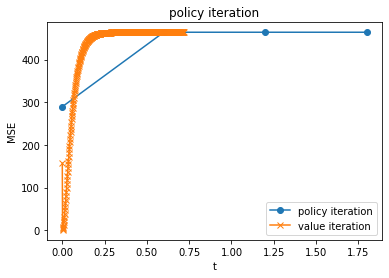

In [89]:
tidx1 = np.arange(0,time1,time1/(len(vs1)+1))[:len(vs1)]
plt.plot(tidx1, list(map(lambda x: np.mean((x - V_c)**2), vs1)), '-o', label='policy iteration')
tidx2 = np.arange(0,time2,time2/(len(vs2)+1))[:len(vs2)]
plt.plot(tidx2, list(map(lambda x: np.mean((x - V_c)**2), vs2)), '-x', label='value iteration')
plt.legend()
plt.xlabel('t')
plt.ylabel('MSE')
plt.title('policy iteration')

**e**) Plot the resulting behavior.

In [84]:
seq = np.array(mdpc.sample_sequence(policy1, 100)).T
discounting = [mdpc.gamma**t for t in range(0,100)]

Text(0, 0.5, 'return')

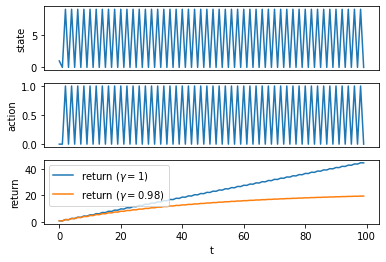

In [90]:
plt.subplot(3,1,1)
plt.plot(seq[0],label='state')
# plt.xlabel('t')
plt.xticks([])
plt.ylabel('state')
plt.subplot(3,1,2)
plt.plot(seq[1],label='action')
# plt.xlabel('t')
plt.xticks([])
plt.ylabel('action')
plt.subplot(3,1,3)
plt.plot(np.cumsum(seq[2]),label='return ($\gamma=1$)')
plt.plot(np.cumsum(seq[2] * discounting),label='return ($\gamma=$' + str(mdpc.gamma) + ')' )
plt.legend()
plt.xlabel('t')
plt.ylabel('return')

### 3. Monte Carlo Methods
*(2 point)*


**a**) Determine the state-values under the optimal policy for the CircleWorld MDP above using on-policy, first-visit MC:
*(1 point)*

In [91]:
def onpolicy_firstvisit_prediction_v(mdp, policy, num_simulations=30):
    # Conditions for convergence
    assert(mdp.task == 'episodic')
    V = np.zeros(mdp.n_states)
    returns = dict()
    Vs = []
    for i in range(num_simulations):
        touched = np.zeros(mdp.n_states)
        seq = mdp.sample_sequence(policy)
        # Traverse sequence backwards
        G = 0
        for state, action, reward in reversed(seq):
            G = # TODO
            if touched[state]:
                returns[state][-1] = G
            else:
                if state not in returns:
                    returns[state] = []
                returns[state].append(G)
            # Update V based on new return
            V[state] = np.sum(returns[state]) / float(len(returns[state]))
        Vs.append(copy.copy(V))
    return V, Vs

SyntaxError: ignored

In [92]:
V, Vs = onpolicy_firstvisit_prediction_v(mdpe, mdpe.optimal_policy(), num_simulations=200)

NameError: ignored

In [ ]:
plt.plot(list(map(lambda x: np.mean((x - V_e)**2), Vs)), '-o', label='state value')
plt.plot(list(map(lambda x: np.mean((mdpe.v_to_q(x) - Q_e)**2), Vs)), '-x', label='action value')
plt.legend()
plt.xlabel('t')
plt.ylabel('MSE')

**b**) Starting from a uniform random policy, solve the control problem (optimize the policy) using on-policy, first-visit MC control:
*(1 point)*

In [ ]:
def onpolicy_firstvisit_control(mdp, policy, num_simulations=30, epsilon=0.01):
    """
    Run the Monte Carlo First Visit On-Policy algorithm and return the estimated
    policy, Q (state action) values, and returns (rewards) dict.
    Uses epsilon-soft policies instead of exploring states (the latter starts in all possible state-action pairs)
    p. 109 of S&B

    Parameters
    ----------
    mdp:
    policy: any epsilon soft policy; e.g. mdp.uniform_stochastic_policy()
    num_simulations : int
        Number of episodes for the policy iteration process
    epsilon-soft

    Returns
    -------
    numpy.ndarray
        Estimated Policy
    numpy.ndarray
        Estimated Q (state-action) values
    dict
        Rewards obtained for every state
    """
    # Conditions for convergence
    assert(mdp.task == 'episodic')

    Q = np.zeros([mdp.n_states, mdp.n_actions])
    returns = dict()
    Qs = []
    for i in range(num_simulations):
        touched = np.zeros([mdp.n_states, mdp.n_actions])
        seq = mdp.sample_sequence(policy)
        # Traverse sequence backwards
        G = 0
        for state, action, reward in reversed(seq):
            tupl = (state, action)
            G = # TODO
            if touched[state, action]:
                returns[tupl][-1] = G
            else:
                if tupl not in returns:
                    returns[tupl] = []
                returns[tupl].append(G)
            # Update Q based on new return
            Q[state, action] = np.sum(returns[tupl]) / float(len(returns[tupl]))
        # update epsilon soft policy
        for state, _, _ in seq:
            # randomly break ties
            a_max = np.random.choice(np.flatnonzero(Q[state] == np.max(Q[state])))
            policy[state,:] = # TODO
            policy[state, a_max] = # TODO
        Qs.append(copy.copy(Q))
    return policy, Qs

In [ ]:
policy0 = uniform_stochastic_policy(mdpe.n_states, mdpc.n_actions)
policy, Qs = onpolicy_firstvisit_control(mdpe, policy0, num_simulations=10000, epsilon=0.01)

print('Policy after on-policy MCMC:')
print(policy)

mdpe.print_value(Qs[-1])
mdpe.print_value(Q_e)

In [ ]:
plt.plot(list(map(lambda x: np.mean((mdpe.q_to_v(x, policy) - V_e)**2), Qs)), '-o', label='state value')
plt.plot(list(map(lambda x: np.mean((x - Q_e)**2), Qs)), '-x', label='action value')
plt.legend()
plt.xlabel('t')
plt.ylabel('MSE')

### 4. TD-methods
*(3 points)*

**a**) Implement and run TD(0) to estimate the value function under the optimal policy
*(1 point)*

In [ ]:
def td0_prediction(mdp, policy, num_simulations=30, alpha = 0.01):
    # Conditions for convergence; note that we can also run on continuing problems
    assert(mdp.task == 'episodic')
    V = np.zeros(mdp.n_states)
    Vs = []
    for i in range(num_simulations):
        s = mdp.sample_initial()
        while not mdp.is_terminal(s):
            a = mdp.sample_action(s, policy)
            (s1, r) = mdp.sample_transition(s, a)
            V[s] += alpha * # TODO
            s = s1
        Vs.append(copy.copy(V))
    return V, Vs

In [ ]:
plt.plot(list(map(lambda x: np.mean((x - V_e)**2), Vs)), '-o', label='state value')
plt.plot(list(map(lambda x: np.mean((mdpe.v_to_q(x) - Q_e)**2), Vs)), '-x', label='action value')
plt.legend()
plt.xlabel('t')
plt.ylabel('MSE')

**b**) Implement and run the SARSA algorithm to estimate the optimal policy
*(1 point)*

In [ ]:
def sarsa(mdp, num_simulations=30, alpha=0.01, epsilon=0.1):
    # Conditions for convergence; note that we can also run on continuing problems
    assert(mdp.task == 'episodic')
    Q = np.zeros([mdp.n_states, mdp.n_actions])
    policy = uniform_stochastic_policy(mdp.n_states, mdp.n_actions)
    Qs = []

    for t in range(num_simulations):
        s = mdp.sample_initial()
        a = mdp.sample_action(s, policy)
        while not mdp.is_terminal(s):
            (s1, r) = mdp.sample_transition(s, a)
            a1 = mdp.sample_action(s1, policy)
            Q[s, a] += alpha * # TODO

            # update policy
            a_max = np.random.choice(np.flatnonzero(Q[s] == np.max(Q[s])))
            policy[s, :] = epsilon / mdp.n_actions
            policy[s, a_max] = # TODO
            s = s1
            a = a1
        Qs.append(copy.copy(Q))
    return policy, Q, Qs

In [ ]:
policy, Q, Qs = sarsa(mdpe, num_simulations=10000, alpha=0.01, epsilon=0.1)

In [ ]:
plt.plot(list(map(lambda x: np.mean((mdpe.q_to_v(x, policy) - V_e)**2), Qs)), '-o', label='state value')
plt.plot(list(map(lambda x: np.mean((x - Q_e)**2), Qs)), '-x', label='action value')
plt.legend()
plt.xlabel('t')
plt.ylabel('MSE')

**c**) Implement and run the Q-learning algorithm to estimate the optimal policy.
*(1 point)*

In [ ]:
def qlearning(mdp, behavioral_policy, num_simulations=30, alpha=0.01, epsilon=0.1):
    # Conditions for convergence; note that we can also run on continuing problems
    assert(mdp.task == 'episodic')

    Q = np.zeros([mdp.n_states, mdp.n_actions])
    Qs = []

    for t in range(num_simulations):
        s = mdp.sample_initial()
        while not mdp.is_terminal(s):
            a = mdp.sample_action(s, behavioral_policy)
            (s1, r) = mdp.sample_transition(s, a)
            Q[s, a] += alpha * # TODO
            s = s1
        Qs.append(copy.copy(Q))
    # determine policy from Q function
    target_policy = np.zeros([mdp.n_states, mdp.n_actions])
    for state in mdp.terminal_states():
        target_policy[state,:] = 1.0 / mdp.n_actions
    for state in mdp.nonterminal_states():
        a_max = np.random.choice(np.flatnonzero(Q[state] == np.max(Q[state])))
        target_policy[state, a_max] = 1.0

    return target_policy, Q, Qs

In [ ]:
b_policy = uniform_stochastic_policy(mdpe.n_states, mdpe.n_actions)
policy, Q, Qs = qlearning(mdpe, behavioral_policy=b_policy, num_simulations=2000, alpha=0.01)

In [ ]:
plt.plot(list(map(lambda x: np.mean((mdpe.q_to_v(x, policy) - V_e)**2), Qs)), '-o', label='state value')
plt.plot(list(map(lambda x: np.mean((x - Q_e)**2), Qs)), '-x', label='action value')
plt.legend()
plt.xlabel('t')
plt.ylabel('MSE')